In [ ]:
# # # CONTENT:

# # 1. Price Volatility Across Cryptocurrencies.
   # 1.A Calculate daily percentage changes for Bitcoin, Ethereum, and Binance Coin.
   # 1.B Perform an F-test to compare variances.
   # 1.C Visualize the daily percentage changes for all cryptocurrencies on the graphs.

# # 2. Correlation Between Cryptocurrencies.
   # 2.A Compute the Pearson correlation coefficient between Bitcoin, Ethereum, and Binance Coin prices.
   # 2.B Create a heatmap.

# # 3. Price Trend Analysis.
   # 3.A Perform linear regression with time as the independent variable and currency prices as the dependent variables.
   # 3.B Visualisation.

# # 4. Comparing Average Prices.
   # 4.A Perform one-way ANOVA to compare the means of Bitcoin, Ethereum, and Binance Coin prices.
   # 4.B Calculate Mean for each cryptocurrency.
   # 4.C Boxplots to compare the distributions of cryptocurrency prices.

# # 5. Seasonality and Monthly Patterns, Forecasting.
   # 5.A Group prices by month and check for significant differences.
   # 5.B Create individual plots for each cryptocurrency.
   # 5.C Use Facebook Prophet and plot 1-year forecast for Bitcoin, Ethereum, and Binance Coin.

# # 6. The mutual Impact of Cryptocurrencies on each other.
   # 6.A Use Granger causality to determine if currencies affect each other.
   # 6.B Scatterplot.

In [2]:
import requests
import pandas as pd
import os

# Get historical data from Binance API
def get_binance_data(crypto_id, vs_currency, start_date, end_date):
    url = "https://api.binance.com/api/v3/klines"
    symbol = f"{crypto_id}{vs_currency}"
    params = {
        'symbol': symbol,
        'interval': '1d',
        'startTime': start_date * 1000,
        'endTime': end_date * 1000,
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None

# Fetch and save data for a single cryptocurrency
def fetch_data_by_year(crypto_id, vs_currency, year_start, year_end, save_folder):
    all_data = []
    for year in range(year_start, year_end + 1):
        start_date = int(pd.Timestamp(f"{year}-01-01").timestamp())
        end_date = int(pd.Timestamp(f"{year}-12-31").timestamp())
        print(f"Fetching data for {crypto_id} for {year}...")
        
        year_data = get_binance_data(crypto_id, vs_currency, start_date, end_date)
        if year_data:
            for item in year_data:
                timestamp = item[0]
                price = item[4]  # Closing price
                all_data.append([pd.to_datetime(timestamp, unit='ms'), price])
    
    if all_data:
        df = pd.DataFrame(all_data, columns=["Date", "Price"])
        os.makedirs(save_folder, exist_ok=True)
        file_path = os.path.join(save_folder, f"{crypto_id}_{year_start}_{year_end}_prices.xlsx")
        df.to_excel(file_path, index=False)
        print(f"Data for {crypto_id} saved to {file_path}")

cryptos = ["BTC", "ETH", "BNB"]
vs_currency = "USDT"
save_folder = "data/raw/Cryptocurrency"

for crypto_id in cryptos:
    fetch_data_by_year(crypto_id, vs_currency, 2020, 2024, save_folder)

Fetching data for BTC for 2020...
Fetching data for BTC for 2021...
Fetching data for BTC for 2022...
Fetching data for BTC for 2023...
Fetching data for BTC for 2024...
Data for BTC saved to BTC_2020_2024_prices.xlsx
Fetching data for ETH for 2020...
Fetching data for ETH for 2021...
Fetching data for ETH for 2022...
Fetching data for ETH for 2023...
Fetching data for ETH for 2024...
Data for ETH saved to ETH_2020_2024_prices.xlsx
Fetching data for BNB for 2020...
Fetching data for BNB for 2021...
Fetching data for BNB for 2022...
Fetching data for BNB for 2023...
Fetching data for BNB for 2024...
Data for BNB saved to BNB_2020_2024_prices.xlsx


In [9]:
# Save folder
save_folder = "data/raw/Cryptocurrency"
os.makedirs(save_folder, exist_ok=True)

btc_file = os.path.join(save_folder, "BTC_2020_2024_prices.xlsx")
eth_file = os.path.join(save_folder, "ETH_2020_2024_prices.xlsx")
bnb_file = os.path.join(save_folder, "BNB_2020_2024_prices.xlsx")

btc_data = pd.read_excel(btc_file)
eth_data = pd.read_excel(eth_file)
bnb_data = pd.read_excel(bnb_file)

btc_data.rename(columns={"Price": "Bitcoin_price"}, inplace=True)
eth_data.rename(columns={"Price": "Ethereum_price"}, inplace=True)
bnb_data.rename(columns={"Price": "Binance_Coin_price"}, inplace=True)

# Merge the data on the Date column
combined_data = pd.merge(btc_data, eth_data, on="Date", how="outer")
combined_data = pd.merge(combined_data, bnb_data, on="Date", how="outer")

combined_data.sort_values(by="Date", inplace=True)

# Save combined data
output_file = os.path.join(save_folder, "Cryptocurrency_2020_2024_prices.xlsx")
combined_data.to_excel(output_file, index=False)

In [10]:
input_path = "data/raw/Cryptocurrency/Cryptocurrency_2020_2024_prices.xlsx"
output_folder = "data/raw/Cryptocurrency"
output_file = os.path.join(output_folder, "Fixed_Cryptocurrency_Prices.xlsx")

os.makedirs(output_folder, exist_ok=True)

data = pd.read_excel(input_path)

# Remove the time from the Date column
data['Date'] = pd.to_datetime(data['Date']).dt.date

# Replace commas with dots and format numbers to 2 decimal places
for col in ['Bitcoin_price', 'Ethereum_price', 'Binance_Coin_price']:
    data[col] = data[col].apply(lambda x: f"{float(str(x).replace(',', '.')):.2f}")

data.to_excel(output_file, index=False)

In [5]:
df = pd.read_excel('data/raw/Cryptocurrency/Fixed_Cryptocurrency_Prices.xlsx')

In [ ]:
# # # 1. Price Volatility Across Cryptocurrencies

# # Steps:

# 1.A Calculate daily percentage changes for Bitcoin, Ethereum, and Binance Coin.
# 1.B Perform an F-test to compare variances.
# 1.C Visualize the daily percentage changes for all cryptocurrencies on the graphs.

In [ ]:
import scipy.stats as stats

# Backup of the original DataFrame (to return to the original df then, without change columns)
df_original = df.copy()

In [ ]:
# 1.A Daily percentage changes for Bitcoin, Ethereum, and Binance Coin

df['Bitcoin_pct_change'] = df['Bitcoin_price'].pct_change()
df['Ethereum_pct_change'] = df['Ethereum_price'].pct_change()
df['Binance_Coin_pct_change'] = df['Binance_Coin_price'].pct_change()

# Fill missing values
df.fillna({'Bitcoin_pct_change': 0, 'Ethereum_pct_change': 0, 'Binance_Coin_pct_change': 0}, inplace=True)

In [4]:
# 1.B F-test for variance comparison

f_stat_bt_eth, p_val_bt_eth = stats.levene(df['Bitcoin_pct_change'], df['Ethereum_pct_change'])
f_stat_bt_bc, p_val_bt_bc = stats.levene(df['Bitcoin_pct_change'], df['Binance_Coin_pct_change'])
f_stat_eth_bc, p_val_eth_bc = stats.levene(df['Ethereum_pct_change'], df['Binance_Coin_pct_change'])

print("F-test Bitcoin vs Ethereum:", f_stat_bt_eth, "p-value:", p_val_bt_eth)
print("F-test Bitcoin vs Binance Coin:", f_stat_bt_bc, "p-value:", p_val_bt_bc)
print("F-test Ethereum vs Binance Coin:", f_stat_eth_bc, "p-value:", p_val_eth_bc)

F-test Bitcoin vs Ethereum: 55.723769185329985 p-value: 1.0371339678982944e-13
F-test Bitcoin vs Binance Coin: 33.75022324534728 p-value: 6.801963065074691e-09
F-test Ethereum vs Binance Coin: 0.6722668568327461 p-value: 0.4123159003496869


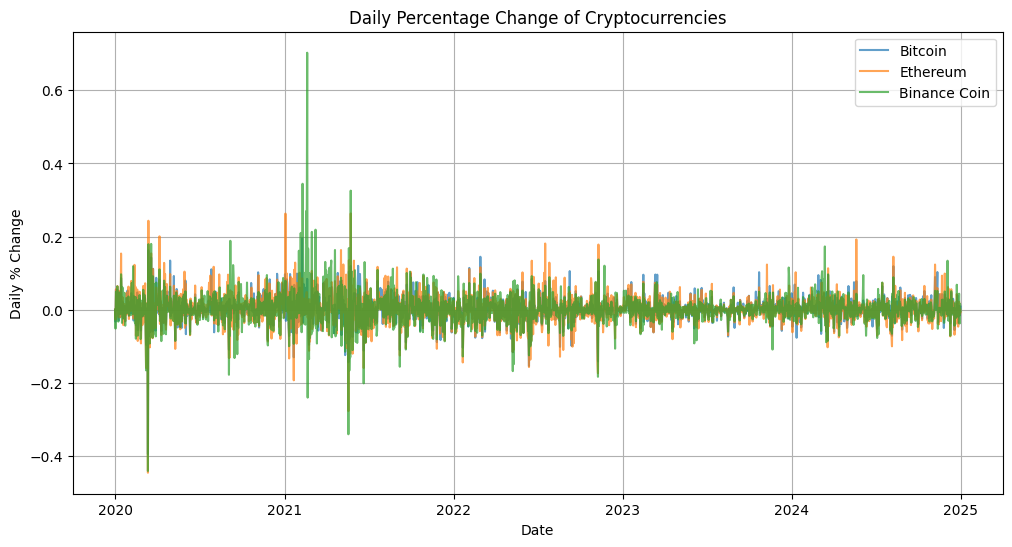

In [5]:
# 1.C Visualize the daily percentage changes for all cryptocurrencies on the graphs

# 1.C.1 Plot the daily percentage changes for all cryptocurrencies on the same graph

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Bitcoin_pct_change'], label='Bitcoin', alpha=0.7)
plt.plot(df['Date'], df['Ethereum_pct_change'], label='Ethereum', alpha=0.7)
plt.plot(df['Date'], df['Binance_Coin_pct_change'], label='Binance Coin', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Daily % Change')
plt.title('Daily Percentage Change of Cryptocurrencies')
plt.legend()
plt.grid()
plt.show()

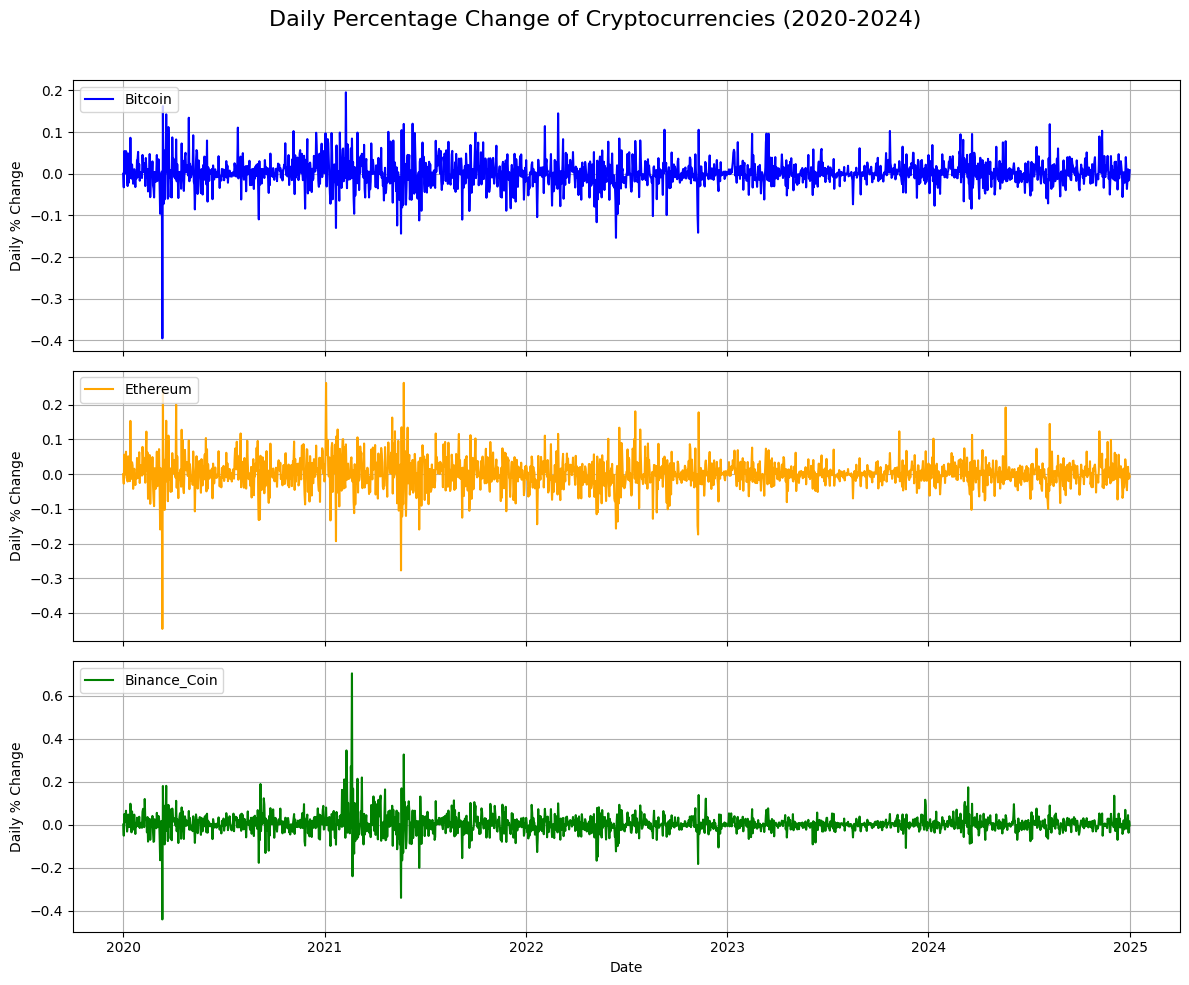

In [6]:
# 1.C.2 Plot the daily percentage changes for all cryptocurrencies on separate charts

import matplotlib.pyplot as plt

# Create subplots for each cryptocurrency
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

cryptos = ['Bitcoin', 'Ethereum', 'Binance_Coin']
colors = ['blue', 'orange', 'green']

for i, crypto in enumerate(cryptos):
    axes[i].plot(df['Date'], df[f'{crypto}_pct_change'], label=crypto, color=colors[i])
    axes[i].set_ylabel('Daily % Change')
    axes[i].legend(loc='upper left')
    axes[i].grid(True)

axes[-1].set_xlabel('Date')
fig.suptitle('Daily Percentage Change of Cryptocurrencies (2020-2024)', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title

plt.show()

In [ ]:
# # # Key Observations

# # Bitcoin vs Ethereum:
# The p-value is extremely small (much less than significance level 0.05). This indicates that there is a statistically significant 
# difference in the variance of prices between Bitcoin and Ethereum over the period analyzed.

# # Bitcoin vs Binance Coin:
# Similarly, the p-value is very small, indicating a significant difference in the variance of prices between Bitcoin and Binance Coin.

# # Ethereum vs Binance Coin:
# The variances of prices between Ethereum and Binance Coin are similar (F-statistic - 0.6727).

In [8]:
print(df.columns)

Index(['Date', 'Bitcoin_price', 'Ethereum_price', 'Binance_Coin_price',
       'Bitcoin_pct_change', 'Ethereum_pct_change', 'Binance_Coin_pct_change'],
      dtype='object')


In [9]:
# To revert to the original DataFrame (without percentage change columns)
df = df_original

In [10]:
# check
print(df.columns)

Index(['Date', 'Bitcoin_price', 'Ethereum_price', 'Binance_Coin_price'], dtype='object')


In [ ]:
# # # 2. Correlation Between Cryptocurrencies

# # Steps:

# 2.A Compute the Pearson correlation coefficient between Bitcoin, Ethereum, and Binance Coin prices.
# 2.B Create a heatmap.

In [11]:
# 2.A. Pearson correlation coefficients

corr_bt_eth = df['Bitcoin_price'].corr(df['Ethereum_price'])
corr_bt_bc = df['Bitcoin_price'].corr(df['Binance_Coin_price'])
corr_eth_bc = df['Ethereum_price'].corr(df['Binance_Coin_price'])

print("Correlation Bitcoin vs Ethereum:", corr_bt_eth)
print("Correlation Bitcoin vs Binance Coin:", corr_bt_bc)
print("Correlation Ethereum vs Binance Coin:", corr_eth_bc)

Correlation Bitcoin vs Ethereum: 0.8567793616359446
Correlation Bitcoin vs Binance Coin: 0.8785685732942315
Correlation Ethereum vs Binance Coin: 0.9183533996186262


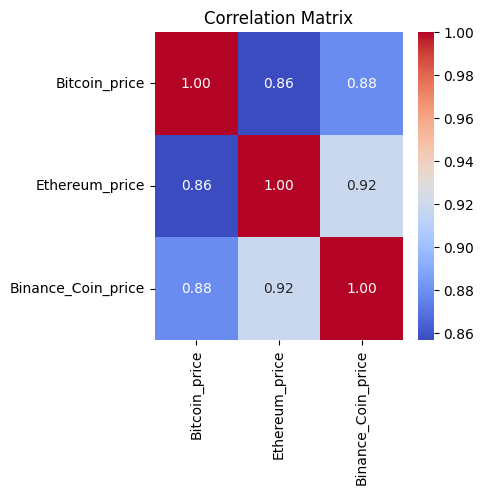

In [12]:
# 2.B. Heatmap

import seaborn as sns

correlation_matrix = df[['Bitcoin_price', 'Ethereum_price', 'Binance_Coin_price']].corr()

plt.figure(figsize=(4, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# # Key Observations

# Correlation Bitcoin vs Ethereum:
# Strong positive correlation (0.857) indicates that the daily percentage changes of Bitcoin and Ethereum move in the same direction most of the time.

# Correlation Bitcoin vs Binance Coin:
# Even higher positive correlation (0.878) suggests that Binance Coin is very closely aligned with Bitcoin's daily changes.

# Correlation Ethereum vs Binance Coin:
# The correlation (0.918) is extremely high. This suggests that these two cryptocurrencies have an even stronger positive relationship 
# than Bitcoin does with either of them.

In [ ]:
# # # 3. Price Trend Analysis

# # Steps:

# 3.A Perform linear regression with time as the independent variable and currency prices as the dependent variables.
# 3.B Visualisation.

In [13]:
# 3.A. Linear regression

from sklearn.linear_model import LinearRegression
import numpy as np

# Convert dates to numerical format for regression
df['Date_numeric'] = pd.to_datetime(df['Date']).map(pd.Timestamp.toordinal)

cryptos = ['Bitcoin_price', 'Ethereum_price', 'Binance_Coin_price']

# Dictionary
trend_results = {}

# Linear regression for each cryptocurrency
for crypto in cryptos:
    X = df[['Date_numeric']]
    y = df[crypto]
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Slope and intercept for each crypto
    trend_results[crypto] = {
        'Slope': model.coef_[0],
        'Intercept': model.intercept_
    }

for crypto, values in trend_results.items():
    print(f"{crypto} Trend Analysis:")
    print(f"  Slope: {values['Slope']:.6f}")
    print(f"  Intercept: {values['Intercept']:.2f}")
    print()

Bitcoin_price Trend Analysis:
  Slope: 24.945074
  Intercept: -18381592.12

Ethereum_price Trend Analysis:
  Slope: 1.223749
  Intercept: -901558.47

Binance_Coin_price Trend Analysis:
  Slope: 0.254985
  Intercept: -187958.74



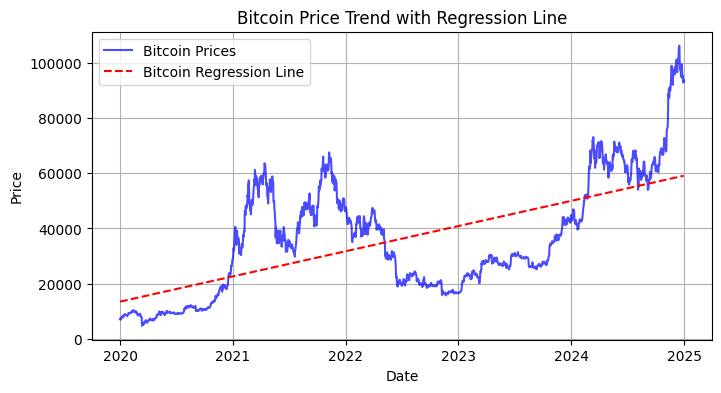

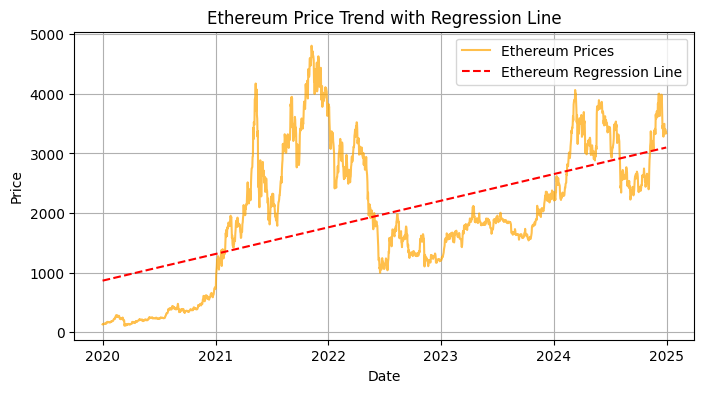

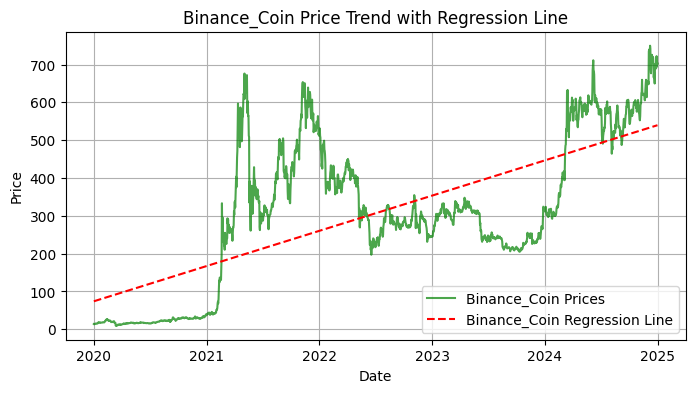

In [14]:
# 3.B. Separate plots for currencies

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd

cryptos = ['Bitcoin', 'Ethereum', 'Binance_Coin']
crypto_columns = ['Bitcoin_price', 'Ethereum_price', 'Binance_Coin_price']
colors = ['blue', 'orange', 'green']

for i, crypto in enumerate(cryptos):
    
    X = df[['Date_numeric']]
    y = df[crypto_columns[i]]

    # Linear regression
    model = LinearRegression()
    model.fit(X, y)

    regression_line = model.coef_[0] * df['Date_numeric'] + model.intercept_

    plt.figure(figsize=(8, 4))
    plt.plot(df['Date'], df[crypto_columns[i]], label=f'{crypto} Prices', alpha=0.7, color=colors[i])
    plt.plot(df['Date'], regression_line, color='red', linestyle='--', label=f'{crypto} Regression Line')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{crypto} Price Trend with Regression Line')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# # # Key Observations

# # Bitcoin Price Trend:
# Slope: 24.933680 - A significant upward trend, prices increasing on average by approximately $24.93 per day over the analyzed period.

# # Ethereum Price Trend:
# Slope: 1.222428 - Prices show a moderate upward trend, increasing by approximately $1.22 per day on average over the analyzed period.
    
# # Binance Coin Price Trend:
# Slope: 0.254877 - Prices have a very gradual upward trend, increasing by about $0.25 per day on average.

# # Note: The intercept is a regression artifact representing the hypothetical price at the origin of the numerical time scale 
# and does not carry practical significance in this analysis.

In [ ]:
# # # 4. Comparing Average Prices

# # Steps:

# 4.A Perform one-way ANOVA to compare the means of Bitcoin, Ethereum, and Binance Coin prices.
# 4.B Calculate Mean for each cryptocurrency.
# 4.C Boxplots to compare the distributions of cryptocurrency prices.

In [15]:
# 4.A. ANOVA

f_stat, p_val = stats.f_oneway(df['Bitcoin_price'], df['Ethereum_price'], df['Binance_Coin_price'])
print("ANOVA F-statistic:", f_stat, "p-value:", p_val)

ANOVA F-statistic: 5058.5676774887015 p-value: 0.0


In [44]:
# 4.B. Mean for each cryptocurrency

mean_values = df_melted.groupby('Cryptocurrency')['Price'].mean()

print(mean_values)

Cryptocurrency
Binance_Coin_price      306.702162
Bitcoin_price         36304.237718
Ethereum_price         1981.848013
Name: Price, dtype: float64


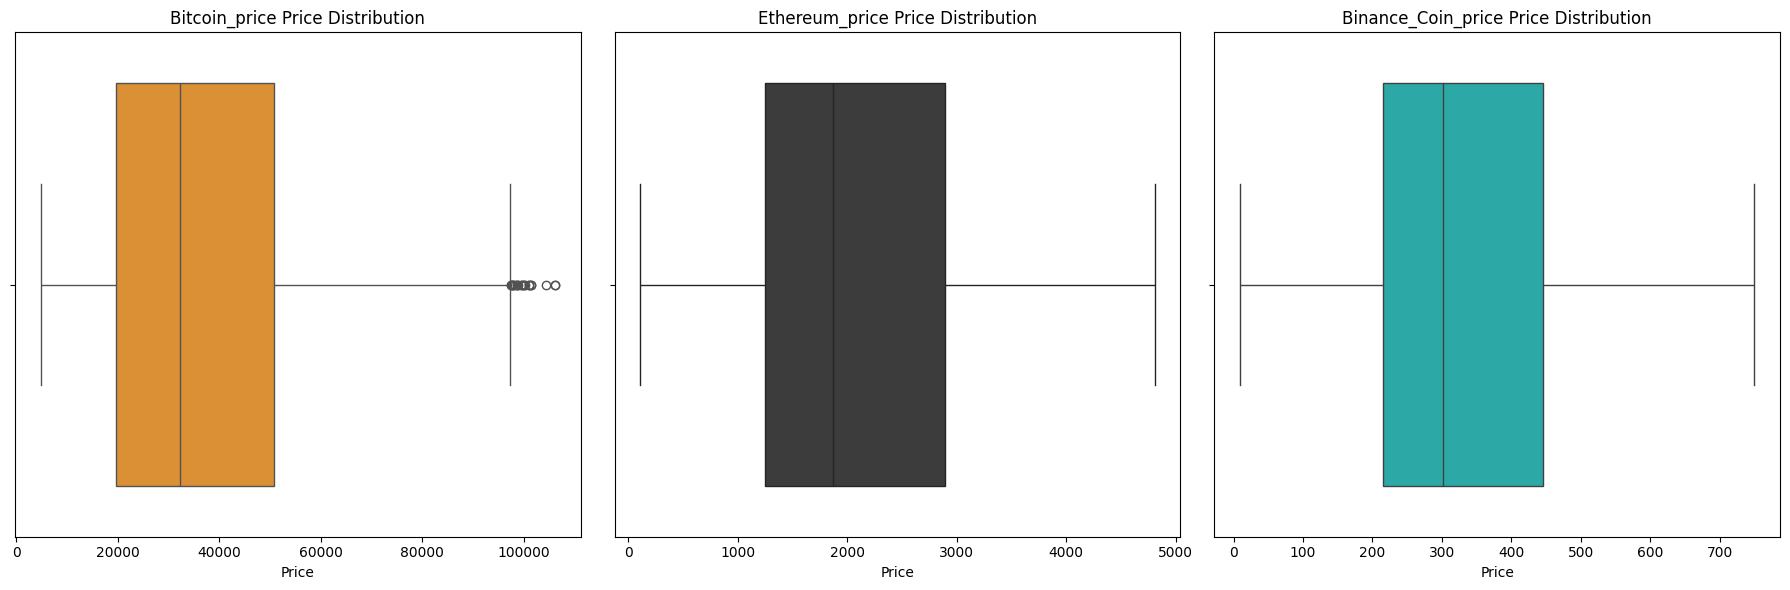

In [8]:
# 4.C. Boxplots 

import matplotlib.pyplot as plt
import seaborn as sns

# Melt the dataframe for easier plotting
df_melted = df[['Bitcoin_price', 'Ethereum_price', 'Binance_Coin_price']].melt(var_name='Cryptocurrency', value_name='Price')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

cryptos = ['Bitcoin_price', 'Ethereum_price', 'Binance_Coin_price']
colors = ['#F7931A', '#3C3C3D', '#17BEBB']  

for i, (crypto, color) in enumerate(zip(cryptos, colors)):
    sns.boxplot(x='Price', data=df_melted[df_melted['Cryptocurrency'] == crypto], ax=axes[i], color=color)
    axes[i].set_title(f'{crypto} Price Distribution')
    axes[i].set_xlabel('Price')

plt.tight_layout()
plt.show()

In [ ]:
# # Key Observations:

# large F-statistic suggests a strong difference in the means of Bitcoin, Ethereum, and Binance Coin prices.

# Boxplots show that Bitcoin prices have a significantly larger range compared to Ethereum and Binance Coin.

# Ethereum prices exhibit a much smaller range compared to Bitcoin but larger than Binance Coin.

# The mean value for Binance Coin is significantly lower than both Bitcoin and Ethereum.

In [ ]:
# # # 5. Seasonality and Monthly Patterns, Forecasting

# # Steps:

# 5.A Group prices by month and check for significant differences.
# 5.B Create individual plots for each cryptocurrency.
# 5.C Use Facebook Prophet and plot 1-year forecast for Bitcoin, Ethereum, and Binance Coin.

In [27]:
# 5.A. Group prices, calculate the Mean

# Create a new column 'Month_Year' combining the month and year

import pandas as pd

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Ensure that 'Month_Year' is generated correctly ('M' - monthly period)
df['Month_Year'] = df['Date'].dt.to_period('M')

monthly_avg = df.groupby('Month_Year')[['Bitcoin_price', 'Ethereum_price', 'Binance_Coin_price']].mean()

# Sort by 'Month_Year'
monthly_avg = monthly_avg.sort_index()

print("\nMonthly Average Prices:")
print(monthly_avg)


Monthly Average Prices:
            Bitcoin_price  Ethereum_price  Binance_Coin_price
Month_Year                                                   
2020-01       8377.592581      156.573226           16.277742
2020-02       9633.430345      238.623103           21.924828
2020-03       6862.995806      160.134839           14.085161
2020-04       7212.127000      171.286667           15.171000
2020-05       9254.304194      207.407097           16.581613
2020-06       9481.804667      235.856333           16.558000
2020-07       9592.066129      259.530323           17.823226
2020-08      11640.994194      401.726452           22.507419
2020-09      10641.700667      367.815333           25.485333
2020-10      11883.404516      375.766129           29.478710
2020-11      16658.474333      486.820333           28.828333
2020-12      21977.935161      622.328710           31.491290
2021-01      34715.923548     1200.769677           41.764516
2021-02      46269.023214     1699.623214    

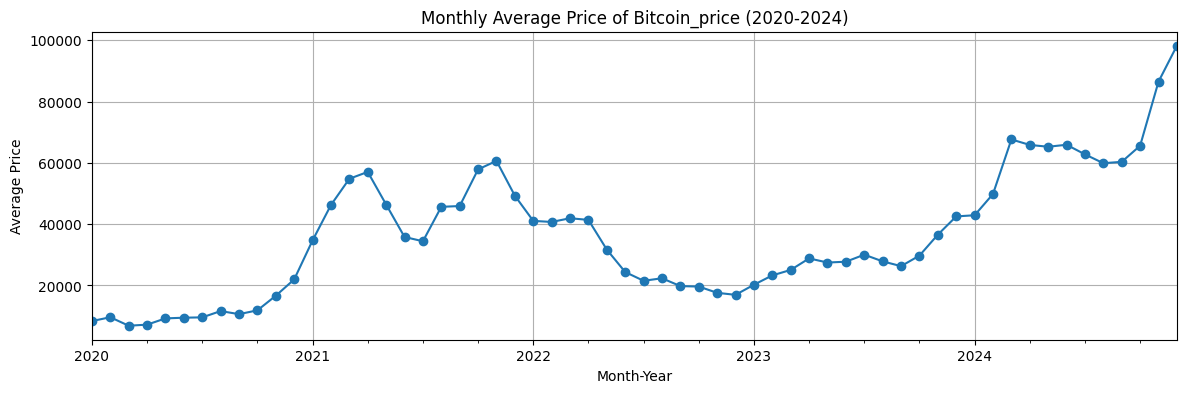

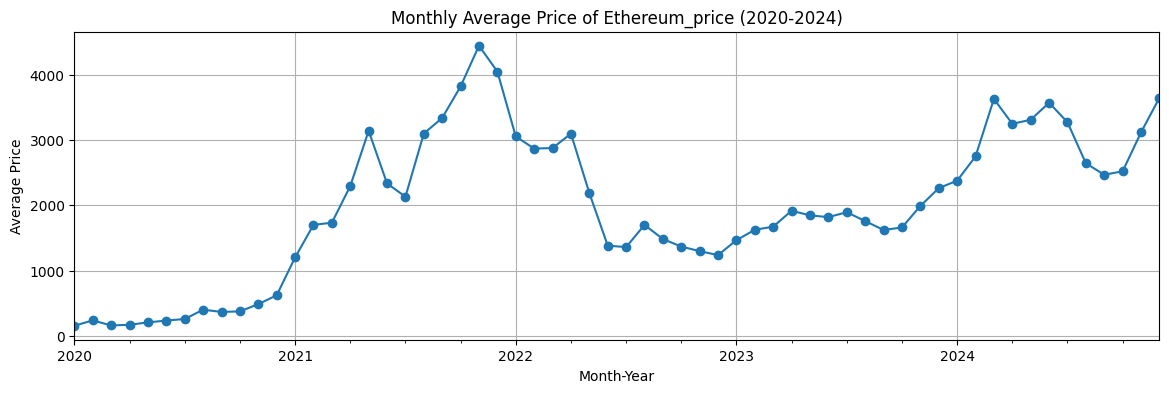

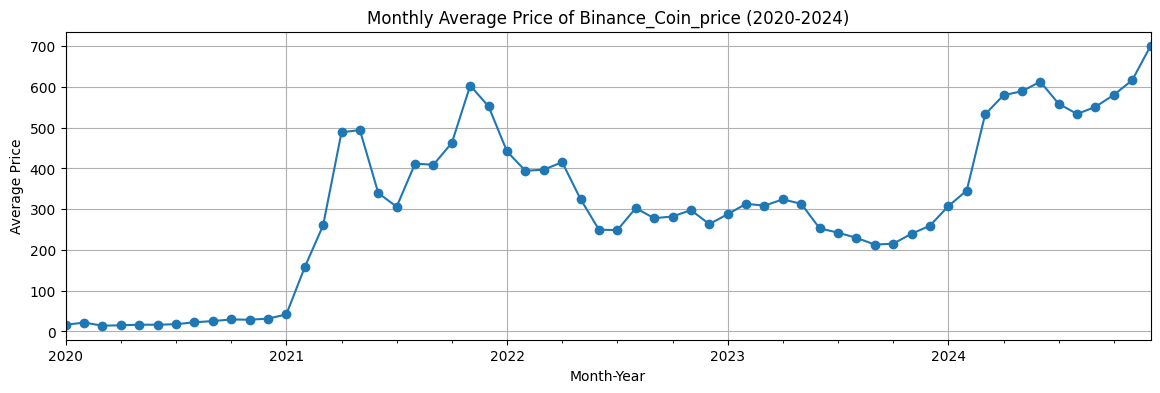

In [28]:
# 5.B. Create individual plots

import matplotlib.pyplot as plt

cryptos = ['Bitcoin_price', 'Ethereum_price', 'Binance_Coin_price']

for crypto in cryptos:
    plt.figure(figsize=(14, 4))
    
    monthly_avg[crypto].plot(kind='line', marker='o')
    
    plt.xlabel('Month-Year')
    plt.ylabel('Average Price')
    plt.title(f'Monthly Average Price of {crypto} (2020-2024)')
    plt.grid(True)
    
    plt.show()

In [ ]:
# # Patterns: 
# Prices for all cryptocurrencies show a tendency to increase toward the end of each year, likely due to seasonal investment behaviors 
# and anticipation of new market developments.
# Prices often decline or stabilize during mid-year months (e.g., July 2022 and 2023), potentially due to lower trading volumes or reduced market 
# activity.

09:23:07 - cmdstanpy - INFO - Chain [1] start processing
09:23:07 - cmdstanpy - INFO - Chain [1] done processing


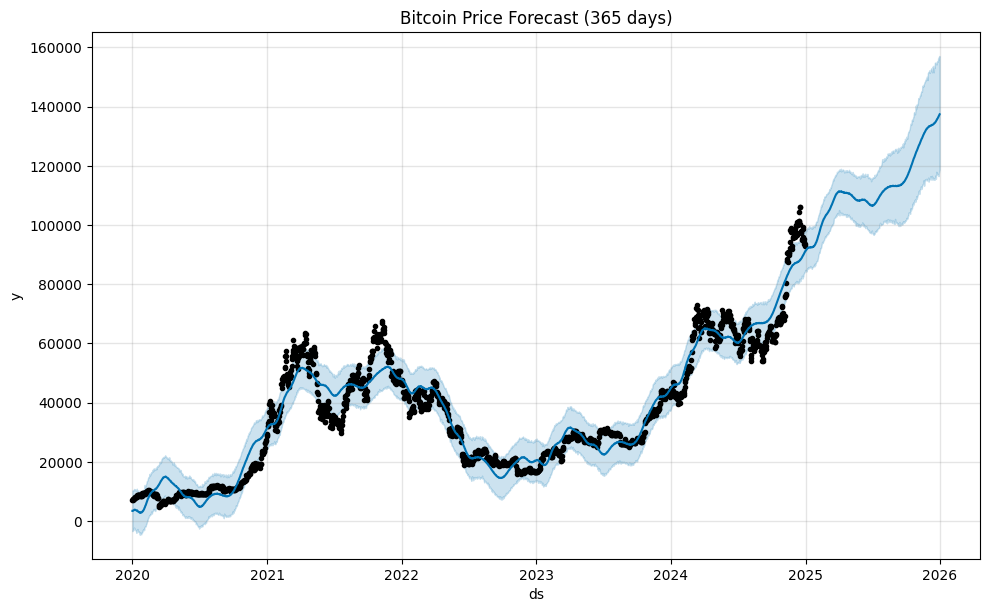

09:23:08 - cmdstanpy - INFO - Chain [1] start processing
09:23:08 - cmdstanpy - INFO - Chain [1] done processing


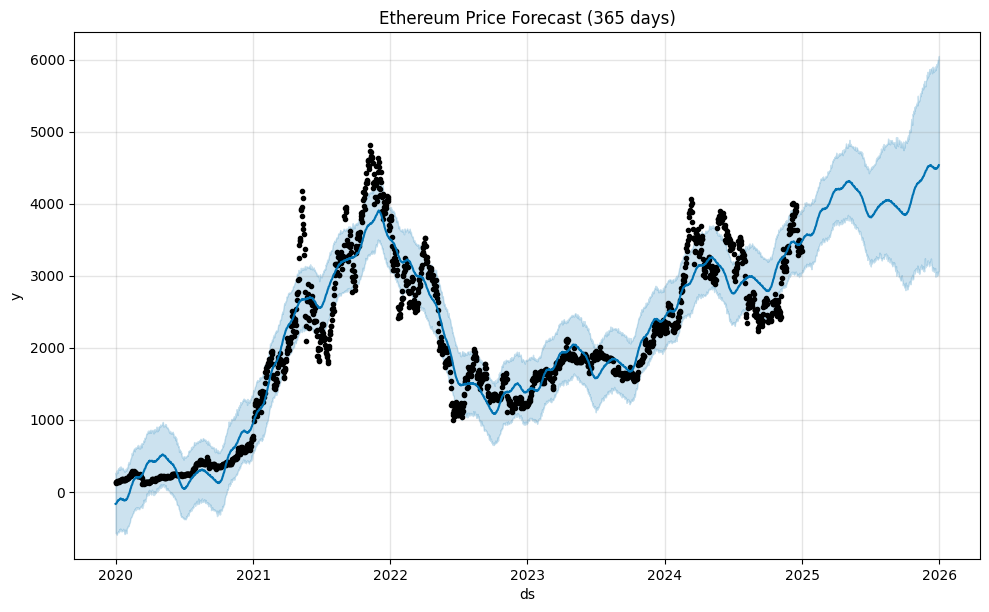

09:23:10 - cmdstanpy - INFO - Chain [1] start processing
09:23:10 - cmdstanpy - INFO - Chain [1] done processing


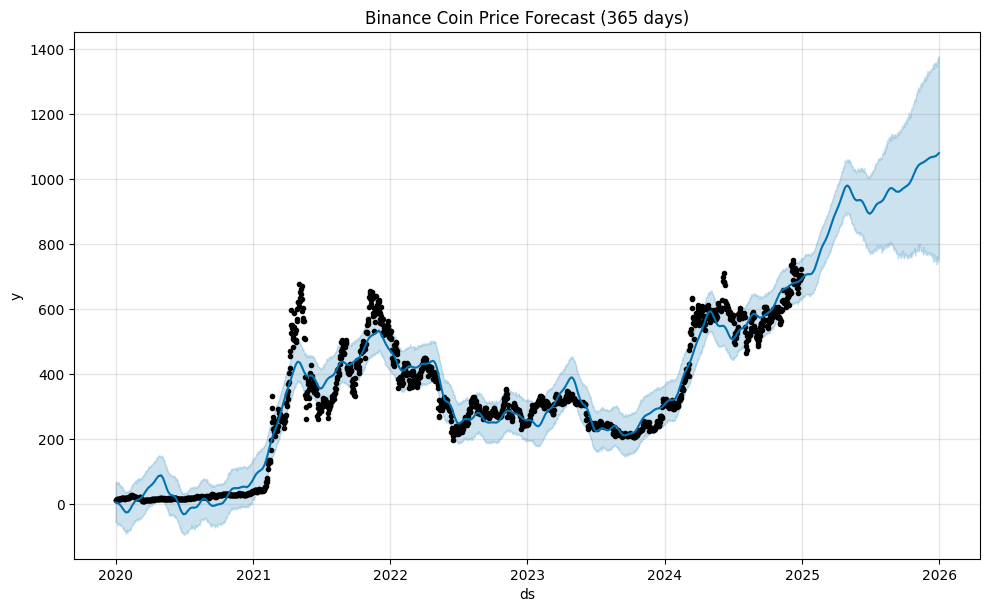

In [19]:
# 5.C. Facebook Prophet
# Note: Prophet is user-friendly, handles seasonality automatically, and is faster than SARIMAX

from prophet import Prophet
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df['Date'])

def forecast_and_plot(currency_column, currency_name, periods=365):  # Default to 1 year
    try:
        currency_df = df[['Date', currency_column]].rename(columns={'Date': 'ds', currency_column: 'y'})
        
        model = Prophet()
        
        model.fit(currency_df)
        
        # Create a dataframe with future dates
        future = model.make_future_dataframe(periods=periods)
        
        forecast = model.predict(future)
        
        model.plot(forecast)
        plt.title(f'{currency_name} Price Forecast ({periods} days)')
        plt.show()
    except Exception as e:
        print(f"Error processing {currency_name}: {e}")

forecast_and_plot('Bitcoin_price', 'Bitcoin', periods=365)  
forecast_and_plot('Ethereum_price', 'Ethereum', periods=365)
forecast_and_plot('Binance_Coin_price', 'Binance Coin', periods=365)

In [ ]:
# # Key Observations: 

# All three cryptocurrencies exhibit a long-term upward trend over the next year (365 days), as projected by the Prophet model.

# The forecasts for each cryptocurrency show seasonal patterns and periodic dips.

# The confidence intervals (shaded areas) reflect higher uncertainty for long-term predictions. 

# Bitcoin: The model forecasts a significant upward trajectory, with prices potentially reaching $150,000–$160,000 by early 2026.

# Ethereum: Prices show a similar growth trend, potentially reaching around $5,000–$6,000 by early 2026.

# Binance Coin: Currency demonstrates consistent growth, with prices forecasted to exceed $1,200–$1,400 by early 2026.

# While the general trends are upward, the uncertainty emphasizes the importance of considering external factors like regulatory changes, 
# market sentiment, and macroeconomic conditions.

In [ ]:
# # # 6. The mutual Impact of Cryptocurrencies on each other

# # Steps:

# 6.A Use Granger causality to determine if currencies affect each other.
# 6.B Scatterplot.

In [23]:
# 6.A. Granger causality

# Perform differencing (to ensure stationarity)
df_diff = df[['Bitcoin_price', 'Ethereum_price', 'Binance_Coin_price']].diff().dropna()

# Granger Causality tests
max_lag = 5  # Adjusted based on data's frequency

# Bitcoin → Ethereum
gc_bitcoin_eth = grangercausalitytests(df_diff[['Bitcoin_price', 'Ethereum_price']], max_lag)

# Bitcoin → Binance Coin
gc_bitcoin_bnb = grangercausalitytests(df_diff[['Bitcoin_price', 'Binance_Coin_price']], max_lag)

# Ethereum → Binance Coin
gc_eth_bnb = grangercausalitytests(df_diff[['Ethereum_price', 'Binance_Coin_price']], max_lag)

# Ethereum → Bitcoin
gc_eth_bitcoin = grangercausalitytests(df_diff[['Ethereum_price', 'Bitcoin_price']], max_lag)

# Binance Coin → Bitcoin
gc_bnb_bitcoin = grangercausalitytests(df_diff[['Binance_Coin_price', 'Bitcoin_price']], max_lag)

# Binance Coin → Ethereum
gc_bnb_eth = grangercausalitytests(df_diff[['Binance_Coin_price', 'Ethereum_price']], max_lag)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8916  , p=0.0050  , df_denom=1822, df_num=1
ssr based chi2 test:   chi2=7.9046  , p=0.0049  , df=1
likelihood ratio test: chi2=7.8875  , p=0.0050  , df=1
parameter F test:         F=7.8916  , p=0.0050  , df_denom=1822, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9724  , p=0.0190  , df_denom=1819, df_num=2
ssr based chi2 test:   chi2=7.9666  , p=0.0186  , df=2
likelihood ratio test: chi2=7.9492  , p=0.0188  , df=2
parameter F test:         F=3.9724  , p=0.0190  , df_denom=1819, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6844  , p=0.0452  , df_denom=1816, df_num=3
ssr based chi2 test:   chi2=8.0844  , p=0.0443  , df=3
likelihood ratio test: chi2=8.0665  , p=0.0447  , df=3
parameter F test:         F=2.6844  , p=0.0452  , df_denom=1816, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9165  , p=0.

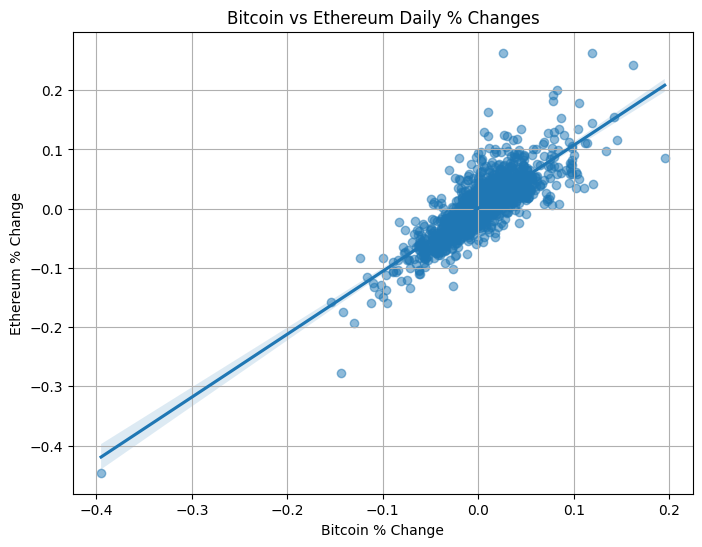

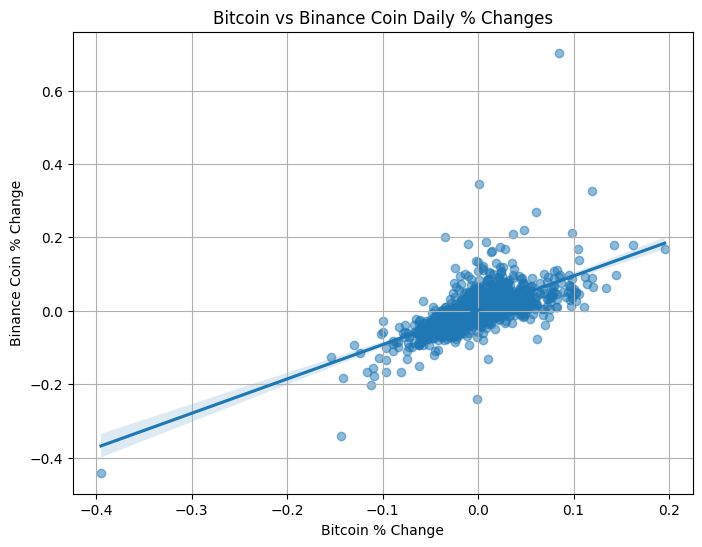

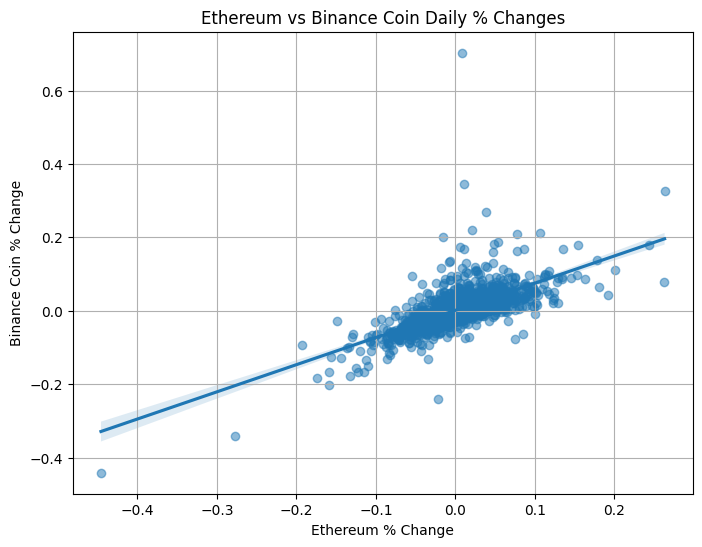

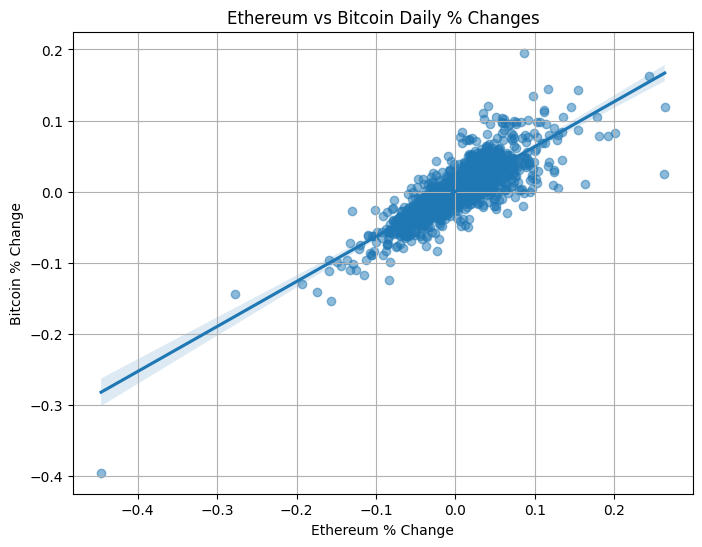

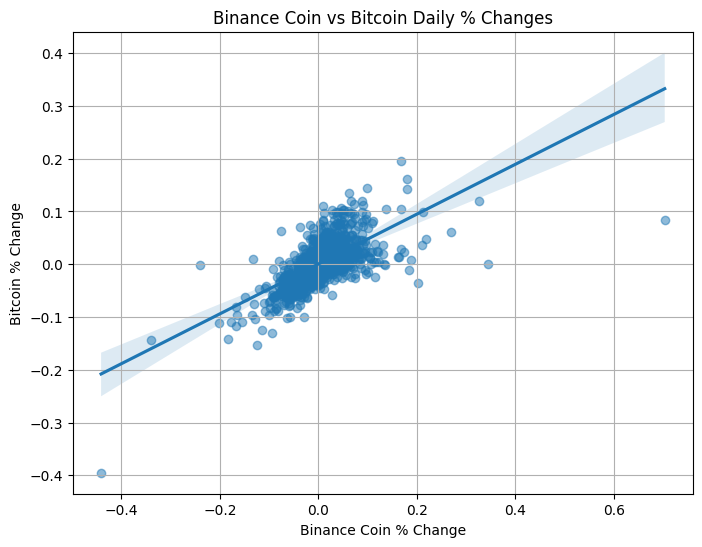

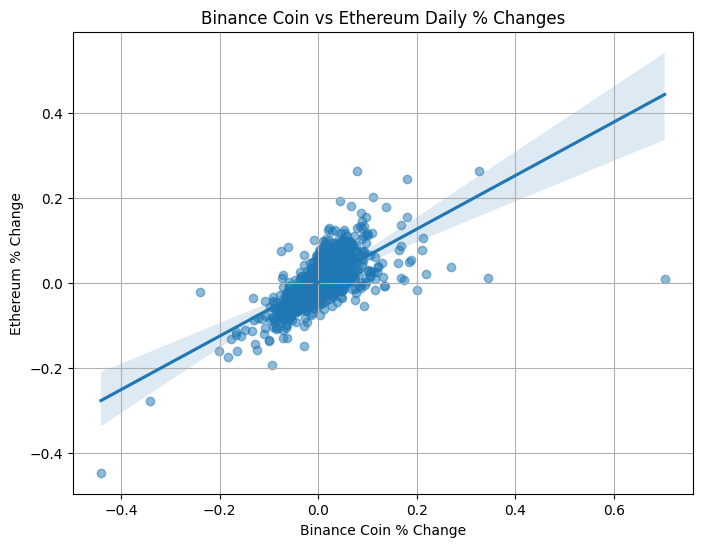

In [35]:
# 6.B. Scatterplot with a regression line to visualize the relationships between changes in currencies prices

# Daily percentage changes
df['Bitcoin_pct_change'] = df['Bitcoin_price'].pct_change()
df['Ethereum_pct_change'] = df['Ethereum_price'].pct_change()
df['Binance_Coin_pct_change'] = df['Binance_Coin_price'].pct_change()

import matplotlib.pyplot as plt
import seaborn as sns

# Bitcoin vs Ethereum
plt.figure(figsize=(8, 6))
sns.regplot(x=df['Bitcoin_pct_change'], y=df['Ethereum_pct_change'], scatter_kws={'alpha':0.5})
plt.title('Bitcoin vs Ethereum Daily % Changes')
plt.xlabel('Bitcoin % Change')
plt.ylabel('Ethereum % Change')
plt.grid()
plt.show()

# Bitcoin vs Binance Coin
plt.figure(figsize=(8, 6))
sns.regplot(x=df['Bitcoin_pct_change'], y=df['Binance_Coin_pct_change'], scatter_kws={'alpha':0.5})
plt.title('Bitcoin vs Binance Coin Daily % Changes')
plt.xlabel('Bitcoin % Change')
plt.ylabel('Binance Coin % Change')
plt.grid()
plt.show()

# Ethereum vs Binance Coin
plt.figure(figsize=(8, 6))
sns.regplot(x=df['Ethereum_pct_change'], y=df['Binance_Coin_pct_change'], scatter_kws={'alpha':0.5})
plt.title('Ethereum vs Binance Coin Daily % Changes')
plt.xlabel('Ethereum % Change')
plt.ylabel('Binance Coin % Change')
plt.grid()
plt.show()

# Ethereum vs Bitcoin
plt.figure(figsize=(8, 6))
sns.regplot(x=df['Ethereum_pct_change'], y=df['Bitcoin_pct_change'], scatter_kws={'alpha':0.5})
plt.title('Ethereum vs Bitcoin Daily % Changes')
plt.xlabel('Ethereum % Change')
plt.ylabel('Bitcoin % Change')
plt.grid()
plt.show()

# Binance Coin vs Bitcoin
plt.figure(figsize=(8, 6))
sns.regplot(x=df['Binance_Coin_pct_change'], y=df['Bitcoin_pct_change'], scatter_kws={'alpha':0.5})
plt.title('Binance Coin vs Bitcoin Daily % Changes')
plt.xlabel('Binance Coin % Change')
plt.ylabel('Bitcoin % Change')
plt.grid()
plt.show()

# Binance Coin vs Ethereum
plt.figure(figsize=(8, 6))
sns.regplot(x=df['Binance_Coin_pct_change'], y=df['Ethereum_pct_change'], scatter_kws={'alpha':0.5})
plt.title('Binance Coin vs Ethereum Daily % Changes')
plt.xlabel('Binance Coin % Change')
plt.ylabel('Ethereum % Change')
plt.grid()
plt.show()

In [ ]:
# # Key Observations:

# Bitcoin is often the driving force in the cryptocurrency market, influencing both Ethereum and Binance Coin. 

# Ethereum has a delayed impact on both Bitcoin and Binance Coin, with significant Granger causality at higher lags, particularly after Ethereum’s price
# moves in the market.

# Binance Coin seems to be more reactive to Bitcoin and Ethereum at delayed intervals, particularly at lags 4 and 5. However, it does not appear to have
# a significant predictive effect on the other cryptocurrencies.